In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat
import pycolmap

from hloc import (
    extract_features,
    match_features,
    pairs_from_poses,
    pairs_from_retrieval,
)
from hloc import triangulation, localize_sfm, visualization

# Generate groundtruth database colmap model

In [ ]:
sevenscenes_utils = __import__("hloc.pipelines.7Scenes.utils", fromlist=[""])

scene = "stairs"
dataset_dir = Path("/local/home/vfrawa/data/7scenes")
gt_dir = dataset_dir / "7scenes_sfm_triangulated" / scene / "triangulated"
ref_sfm_sift = dataset_dir / "outputs" / scene / "ref_sfm_sift"
test_list = gt_dir / "list_test.txt"
ref_sfm_sift.mkdir(parents=True, exist_ok=True)
sevenscenes_utils.create_reference_sfm(gt_dir, ref_sfm_sift, test_list)
reconstruction_ref_sfm_sift = pycolmap.Reconstruction(ref_sfm_sift)
reconstruction_ref_sfm_sift.write_text(ref_sfm_sift)

# Pipeline for point-based SfM from known poses for ScanNet and Hypersim dataset

## Setup
Here we declare the paths to the dataset, the reconstruction and localization outputs, and we choose the feature extractor and the matcher.

In [ ]:
#scannet
# scene_dir = Path("/local/home/vfrawa/data/ScanNet/scans/scene0191_00")
# images = scene_dir / "sensorstream" #sensorstream_sample #low_light05_no_noise_no_smaller_contrast
# empty_colmap_model_with_known_poses = scene_dir / "formats" / "empty_colmap_model_known_poses" #"formats_sample" / "empty_colmap_model_known_poses"
# outputs = scene_dir / "outputs_hloc" / "test_31_12"

#hypersim
# scene_dir = Path("/local/home/vfrawa/data/hypersim/")
# images = scene_dir / "images"
# empty_colmap_model_with_known_poses = scene_dir / "formats" / "empty_db_colmap_model_known_poses"
# outputs = scene_dir / "outputs_hloc/test4_with_db_query_split" # where everything will be saved
# db_list_path = scene_dir / "formats" / "db_list.txt"
# query_list_path = scene_dir / "formats" / "query_list.txt"
# query_list_with_intrinsics_path = scene_dir / "formats" / "query_list_with_intrinsics.txt"

#7scenes
scene = "stairs"
dataset_dir = Path("/local/home/vfrawa/data/7scenes")
images = dataset_dir / scene
empty_colmap_model_with_known_poses = dataset_dir / "outputs" / scene / "ref_sfm_sift"
gt_dir = dataset_dir / "7scenes_sfm_triangulated" / scene / "triangulated"
outputs = dataset_dir / "outputs" / scene / "outputs_hloc/test"
query_list_path = gt_dir / "list_test.txt"

num_sfm_pairs = 20
sfm_pairs = outputs / f"pairs-db-dist{num_sfm_pairs}.txt"
loc_pairs = outputs / "pairs-query-netvlad20.txt"  # top 20 retrieved by NetVLAD
reference_sfm = outputs / "sfm_superpoint+superglue"  # the SfM model we will build
results = outputs / "ScanNet_hloc_superpoint+superglue_netvlad20.txt"  # the result file

# list the standard configurations available
print(f"Configs for feature extractors:\n{pformat(extract_features.confs)}")
print(f"Configs for feature matchers:\n{pformat(match_features.confs)}")

Configs for feature extractors:
{'aliked-n16': {'model': {'model_name': 'aliked-n16', 'name': 'aliked'},
                'output': 'feats-aliked-n16',
                'preprocessing': {'grayscale': False, 'resize_max': 1024}},
 'd2net-ss': {'model': {'multiscale': False, 'name': 'd2net'},
              'output': 'feats-d2net-ss',
              'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'dir': {'model': {'name': 'dir'},
         'output': 'global-feats-dir',
         'preprocessing': {'resize_max': 1024}},
 'disk': {'model': {'max_keypoints': 5000, 'name': 'disk'},
          'output': 'feats-disk',
          'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'eigenplaces': {'model': {'name': 'eigenplaces'},
                 'output': 'global-feats-eigenplaces',
                 'preprocessing': {'resize_max': 1024}},
 'netvlad': {'model': {'name': 'netvlad'},
             'output': 'global-feats-netvlad',
             'preprocessing': {'resize_max': 1024}},
 

In [14]:
# pick one of the configurations for image retrieval, local feature extraction, and matching
# you can also simply write your own here!
retrieval_conf = extract_features.confs["netvlad"] 
feature_conf = extract_features.confs["superpoint_aachen"]  #superpoint_aachen
matcher_conf = match_features.confs["superglue"]

## Extract local features for database and query images

In [15]:
features = extract_features.main(feature_conf, images, outputs)

[2025/02/10 09:18:13 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2025/02/10 09:18:13 hloc INFO] Found 6001 images in root /local/home/vfrawa/data/7scenes/stairs.


Loaded SuperPoint model


/local/home/vfrawa/Hierarchical-Localization_fork/hloc/extractors/../../third_party/SuperGluePretrainedNetwork/models/superpoint.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

The function returns the path of the file in which all the extracted features are stored.

## Generate pairs for the SfM reconstruction
Instead of matching all database images exhaustively, we exploit the known poses to find which image pairs potentially contain a lot of matches.

In [16]:
# colmap_from_nvm.main(
#     dataset / "3D-models/aachen_cvpr2018_db.nvm",
#     dataset / "3D-models/database_intrinsics.txt",
#     dataset / "aachen.db",
#     outputs / "sfm_sift",
# )

# pairs_from_covisibility.main(outputs / "sfm_sift", sfm_pairs, num_matched=20)

pairs_from_poses.main(empty_colmap_model_with_known_poses, sfm_pairs, num_sfm_pairs)

[2025/02/10 09:19:41 hloc INFO] Reading the COLMAP model...


[2025/02/10 09:19:42 hloc INFO] Obtaining pairwise distances between 2000 images...
[2025/02/10 09:19:42 hloc INFO] Found 40000 pairs.


## Match the database images

In [17]:
sfm_matches = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2025/02/10 09:20:15 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


/local/home/vfrawa/Hierarchical-Localization_fork/hloc/extractors/../../third_party/SuperGluePretrainedNetwork/models/superglue.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

The function returns the path of the file in which all the computed matches are stored.

## Triangulate a new SfM model from the given poses
We triangulate the sparse 3D pointcloud given the matches and the reference poses stored in the SIFT COLMAP model.

In [18]:
reconstruction = triangulation.main(
    reference_sfm, empty_colmap_model_with_known_poses, images, sfm_pairs, features, sfm_matches, verbose=True
)

[2025/02/10 09:36:16 hloc INFO] Importing features into the database...
100%|██████████| 2000/2000 [00:00<00:00, 2612.00it/s]
[2025/02/10 09:36:17 hloc INFO] Importing matches into the database...
100%|██████████| 40000/40000 [00:12<00:00, 3310.13it/s]
[2025/02/10 09:36:29 hloc INFO] Performing geometric verification of the matches...
100%|██████████| 2000/2000 [00:55<00:00, 36.01it/s]
[2025/02/10 09:37:25 hloc INFO] mean/med/min/max valid matches 97.95/99.73/0.00/100.00%.
[2025/02/10 09:37:25 hloc INFO] Running 3D triangulation...
I20250210 09:37:25.534480 11168 misc.cc:198] 
Loading database
I20250210 09:37:25.542753 11168 database_cache.cc:54] Loading cameras...
I20250210 09:37:25.542778 11168 database_cache.cc:64]  1 in 0.000s
I20250210 09:37:25.542786 11168 database_cache.cc:72] Loading matches...
I20250210 09:37:25.587081 11168 database_cache.cc:78]  22781 in 0.044s
I20250210 09:37:25.587112 11168 database_cache.cc:94] Loading images...
I20250210 09:37:25.611899 11168 database_ca

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.650722e+06    0.00e+00    1.91e+07   0.00e+00   0.00e+00  1.00e+04        0    1.11e-01    5.89e-01
   1  3.587801e+06    4.06e+06    4.51e+06   4.49e+01   8.20e-01  1.35e+04        0    2.01e-01    7.90e-01
   2  2.870293e+06    7.18e+05    1.05e+06   3.21e+01   7.92e-01  1.69e+04        0    1.94e-01    9.85e-01
   3  2.712776e+06    1.58e+05    2.24e+05   2.82e+01   7.96e-01  2.14e+04        0    1.79e-01    1.16e+00
   4  2.670258e+06    4.25e+04    3.92e+04   2.58e+01   8.20e-01  2.89e+04        0    1.72e-01    1.34e+00
   5  2.655176e+06    1.51e+04    1.65e+04   2.48e+01   8.44e-01  4.28e+04        0    1.73e-01    1.51e+00
   6  2.648531e+06    6.65e+03    1.12e+04   2.59e+01   8.57e-01  6.75e+04        0    1.76e-01    1.69e+00
   7  2.645296e+06    3.23e+03    6.49e+03   2.93e+01   8.62e-01  1.09e+05        0    1.79e-01    1.87e+00
   8  2.643685e+06    1.61e+

I20250210 09:37:52.081315 11168 misc.cc:205] 
Bundle adjustment report
------------------------
I20250210 09:37:52.081344 11168 bundle_adjustment.cc:942] 
    Residuals : 1585162
   Parameters : 222813
   Iterations : 24
         Time : 4.75567 [s]
 Initial cost : 2.19692 [px]
   Final cost : 1.29103 [px]
  Termination : Convergence

I20250210 09:37:52.367290 11168 incremental_mapper.cc:175] => Completed observations: 3845
I20250210 09:37:53.239101 11168 incremental_mapper.cc:178] => Merged observations: 118230
I20250210 09:37:53.556576 11168 incremental_mapper.cc:160] => Filtered observations: 90806
I20250210 09:37:53.556595 11168 sfm.cc:521] => Changed observations: 0.268592
I20250210 09:37:53.869287 11168 misc.cc:198] 
Bundle adjustment


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.135426e+06    0.00e+00    6.03e+04   0.00e+00   0.00e+00  1.00e+04        0    7.90e-02    4.30e-01
   1  1.045642e+06    8.98e+04    6.69e+03   1.49e+01   9.96e-01  3.00e+04        0    1.46e-01    5.76e-01
   2  1.044241e+06    1.40e+03    6.94e+02   4.91e+00   9.90e-01  9.00e+04        0    1.32e-01    7.08e-01
   3  1.044200e+06    4.11e+01    4.24e+01   1.31e+00   9.93e-01  2.70e+05        0    1.35e-01    8.43e-01
   4  1.044200e+06    7.36e-01    9.31e-01   2.17e-01   9.98e-01  8.10e+05        0    1.31e-01    9.75e-01


I20250210 09:37:55.270138 11168 misc.cc:205] 
Bundle adjustment report
------------------------
I20250210 09:37:55.270169 11168 bundle_adjustment.cc:942] 
    Residuals : 1255972
   Parameters : 148482
   Iterations : 5
         Time : 1.00761 [s]
 Initial cost : 0.950801 [px]
   Final cost : 0.911805 [px]
  Termination : Convergence

I20250210 09:37:55.701895 11168 incremental_mapper.cc:175] => Completed observations: 101875
I20250210 09:37:56.329919 11168 incremental_mapper.cc:178] => Merged observations: 83792
I20250210 09:37:56.448585 11168 incremental_mapper.cc:160] => Filtered observations: 3669
I20250210 09:37:56.448602 11168 sfm.cc:521] => Changed observations: 0.301497
I20250210 09:37:56.697821 11168 misc.cc:198] 
Bundle adjustment


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.374384e+06    0.00e+00    6.65e+04   0.00e+00   0.00e+00  1.00e+04        0    8.82e-02    4.77e-01
   1  1.284237e+06    9.01e+04    2.17e+03   9.93e+00   9.97e-01  3.00e+04        0    1.60e-01    6.38e-01
   2  1.283472e+06    7.65e+02    1.30e+02   2.42e+00   9.97e-01  9.00e+04        0    1.49e-01    7.87e-01
   3  1.283461e+06    1.05e+01    3.99e+00   4.07e-01   9.99e-01  2.70e+05        0    1.54e-01    9.42e-01
   4  1.283461e+06    5.62e-02    3.65e-01   3.48e-02   1.00e+00  8.10e+05        0    1.50e-01    1.09e+00


I20250210 09:37:58.268325 11168 misc.cc:205] 
Bundle adjustment report
------------------------
I20250210 09:37:58.268352 11168 bundle_adjustment.cc:942] 
    Residuals : 1445794
   Parameters : 137571
   Iterations : 5
         Time : 1.12917 [s]
 Initial cost : 0.974991 [px]
   Final cost : 0.942189 [px]
  Termination : Convergence

I20250210 09:37:58.559813 11168 incremental_mapper.cc:175] => Completed observations: 10857
I20250210 09:37:59.063475 11168 incremental_mapper.cc:178] => Merged observations: 28067
I20250210 09:37:59.184154 11168 incremental_mapper.cc:160] => Filtered observations: 4558
I20250210 09:37:59.184170 11168 sfm.cc:521] => Changed observations: 0.060150
I20250210 09:37:59.467242 11168 misc.cc:198] 
Bundle adjustment


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.307941e+06    0.00e+00    3.40e+04   0.00e+00   0.00e+00  1.00e+04        0    8.93e-02    4.92e-01
   1  1.287968e+06    2.00e+04    8.91e+02   4.57e+00   9.98e-01  3.00e+04        0    1.80e-01    6.72e-01
   2  1.287805e+06    1.63e+02    4.92e+01   1.19e+00   9.96e-01  9.00e+04        0    1.46e-01    8.18e-01
   3  1.287802e+06    2.58e+00    2.59e+00   2.30e-01   9.99e-01  2.70e+05        0    1.53e-01    9.72e-01
   4  1.287802e+06    2.06e-02    4.46e-01   2.50e-02   1.00e+00  8.10e+05        0    1.49e-01    1.12e+00


I20250210 09:38:01.087814 11168 misc.cc:205] 
Bundle adjustment report
------------------------
I20250210 09:38:01.087867 11168 bundle_adjustment.cc:942] 
    Residuals : 1455076
   Parameters : 134277
   Iterations : 5
         Time : 1.15936 [s]
 Initial cost : 0.948094 [px]
   Final cost : 0.940766 [px]
  Termination : Convergence

I20250210 09:38:01.371749 11168 incremental_mapper.cc:175] => Completed observations: 5834
I20250210 09:38:01.854370 11168 incremental_mapper.cc:178] => Merged observations: 12666
I20250210 09:38:01.966709 11168 incremental_mapper.cc:160] => Filtered observations: 1876
I20250210 09:38:01.966729 11168 sfm.cc:521] => Changed observations: 0.028007
I20250210 09:38:02.254237 11168 misc.cc:198] 
Bundle adjustment


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.302773e+06    0.00e+00    3.75e+04   0.00e+00   0.00e+00  1.00e+04        0    8.98e-02    5.02e-01
   1  1.294459e+06    8.31e+03    6.42e+02   3.09e+00   9.98e-01  3.00e+04        0    1.67e-01    6.69e-01
   2  1.294387e+06    7.24e+01    3.18e+01   8.48e-01   9.95e-01  9.00e+04        0    1.84e-01    8.53e-01
   3  1.294386e+06    1.31e+00    3.91e+00   1.67e-01   1.00e+00  2.70e+05        0    1.64e-01    1.02e+00
   4  1.294386e+06    9.79e-03    6.42e-01   1.61e-02   1.00e+00  8.10e+05        0    1.68e-01    1.19e+00


I20250210 09:38:03.959121 11168 misc.cc:205] 
Bundle adjustment report
------------------------
I20250210 09:38:03.959153 11168 bundle_adjustment.cc:942] 
    Residuals : 1461260
   Parameters : 132936
   Iterations : 5
         Time : 1.22367 [s]
 Initial cost : 0.944215 [px]
   Final cost : 0.94117 [px]
  Termination : Convergence

I20250210 09:38:04.233054 11168 incremental_mapper.cc:175] => Completed observations: 2328
I20250210 09:38:04.680915 11168 incremental_mapper.cc:178] => Merged observations: 4426
I20250210 09:38:04.790762 11168 incremental_mapper.cc:160] => Filtered observations: 971
I20250210 09:38:04.790782 11168 sfm.cc:521] => Changed observations: 0.010573
I20250210 09:38:05.070940 11168 misc.cc:198] 
Extracting colors
[2025/02/10 09:38:15 hloc INFO] Finished the triangulation with statistics:
Reconstruction:
	num_reg_images = 2000
	num_cameras = 1
	num_points3D = 44161
	num_observations = 731444
	mean_track_length = 16.5631
	mean_observations_per_image = 365.722
	mean

In [19]:
reconstruction.write_text(reference_sfm)

## Visualizing the SfM model
We visualize some of the database images with their detected keypoints.

In [49]:
#reconstruction = pycolmap.Reconstruction("/local/home/vfrawa/data/ScanNet/scans/scene0191_00/outputs_colmap/sfm_superpoint+superglue_direct_colmap")

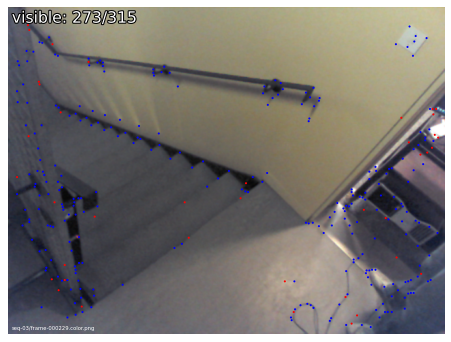

In [20]:
visualization.visualize_sfm_2d(reconstruction, images, color_by="visibility", n=1)

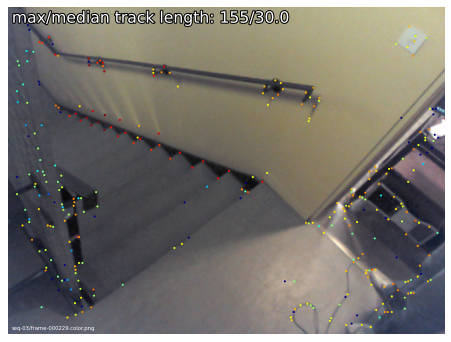

In [21]:
visualization.visualize_sfm_2d(reconstruction, images, color_by="track_length", n=1)

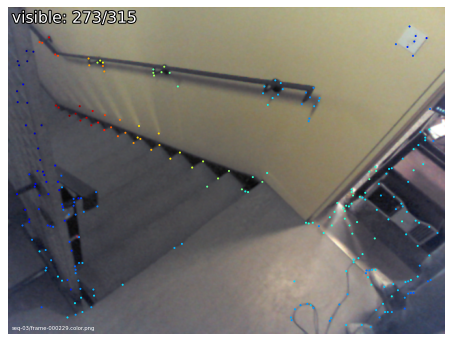

In [22]:
visualization.visualize_sfm_2d(reconstruction, images, color_by="depth", n=1)

# Localization for query images

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the $k$ most similar ones. A larger $k$ improves the robustness of the localization for difficult queries but makes the matching more expensive. Using $k{=}10{-}20$ is generally a good tradeoff but $k{=}50$ gives the best results for the Aachen Day-Night dataset.

In [23]:
global_descriptors = extract_features.main(retrieval_conf, images, outputs)
# pairs_from_retrieval.main(
#     global_descriptors, loc_pairs, num_matched=20, db_list=db_list_path, query_list=query_list_path
# )
# try out with givin in db_model instead of db_list
pairs_from_retrieval.main(global_descriptors, loc_pairs, num_matched=20, db_model=empty_colmap_model_with_known_poses, query_list=query_list_path)

[2025/02/10 09:43:24 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2025/02/10 09:43:24 hloc INFO] Found 6001 images in root /local/home/vfrawa/data/7scenes/stairs.
100%|██████████| 6001/6001 [02:33<00:00, 39.15it/s]
[2025/02/10 09:46:02 hloc INFO] Finished exporting features.
[2025/02/10 09:46:02 hloc INFO] Extracting image pairs from a retrieval database.
[2025/02/10 09:46:06 hloc.utils.parsers INFO] Imported 1000 images from list_test.txt
[2025/02/10 09:46:07 hloc INFO] Found 20000 pairs.


## Match the query images

In [24]:
loc_matches = match_features.main(
    matcher_conf, loc_pairs, feature_conf["output"], outputs
)

[2025/02/10 09:48:02 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


/local/home/vfrawa/Hierarchical-Localization_fork/hloc/extractors/../../third_party/SuperGluePretrainedNetwork/models/superglue.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

## Add query features, matches and estimated two-view geometries to database

After running the code below, the query images and their specifics are also in the database, so that we can use them in the image registrator from colmap.

In [ ]:
from hloc.utils.database import COLMAPDatabase
from hloc.utils.parsers import parse_image_lists
from hloc.triangulation import import_features, import_matches
from hloc.triangulation import estimation_and_geometric_verification

database_path = reference_sfm / "database.db"

queries = parse_image_lists(query_list_path, with_intrinsics=False)
gt_reconstruction = pycolmap.Reconstruction(gt_dir)

#add images to the database
db = COLMAPDatabase.connect(database_path)
all_image_name_to_id = {}
query_image_name_to_id = {}
for image_id, image in gt_reconstruction.images.items():
    all_image_name_to_id[image.name] = image_id
    if image.name in queries:
        query_image_name_to_id[image.name] = image_id
        db.add_image(image.name, image.camera_id, image_id=image_id)
db.commit()
db.close()

# add features of queries into database
import_features(query_image_name_to_id, database_path, features)
# add matches of queries into database
import_matches(all_image_name_to_id, database_path, loc_pairs, loc_matches)
# do geometric verification of query matches with db and add estimated two-view geometries into database
estimation_and_geometric_verification(database_path, loc_pairs, True)

[2025/02/10 10:04:33 hloc.utils.parsers INFO] Imported 1000 images from list_test.txt
[2025/02/10 10:04:33 hloc INFO] Importing features into the database...
100%|██████████| 1000/1000 [00:00<00:00, 2510.84it/s]
[2025/02/10 10:04:33 hloc INFO] Importing matches into the database...
100%|██████████| 20000/20000 [00:10<00:00, 1858.48it/s]
[2025/02/10 10:04:44 hloc INFO] Performing geometric verification of the matches...
I20250210 10:04:44.848201 33686 misc.cc:198] 
Custom feature matching
I20250210 10:04:44.865140 33686 feature_matching.cc:1021] Matching block [1/17]
I20250210 10:04:48.063776 33686 feature_matching.cc:46]  in 3.199s
I20250210 10:04:48.066409 33686 feature_matching.cc:1021] Matching block [2/17]
I20250210 10:04:50.090107 33686 feature_matching.cc:46]  in 2.024s
I20250210 10:04:50.101393 33686 feature_matching.cc:1021] Matching block [3/17]
I20250210 10:04:52.986869 33686 feature_matching.cc:46]  in 2.885s
I20250210 10:04:52.994941 33686 feature_matching.cc:1021] Matching

In [ ]:
# I originally used this for hypersim but the above code should work for both hypersim and 7scenes
from hloc.utils.database import COLMAPDatabase
#from hloc.utils.geometry import compute_epipolar_errors
from hloc.utils.parsers import parse_image_lists
from hloc.triangulation import import_features, import_matches
from hloc.triangulation import estimation_and_geometric_verification
import re

database_path = outputs / "sfm_superpoint+superglue" / "database.db"
all_images = parse_image_lists(db_list_path, with_intrinsics=False) + parse_image_lists(query_list_path, with_intrinsics=False)
all_image_name_to_id = {}
for image_name in all_images:
    # Regular expression to extract the number
    match = re.search(r"image(\d+)\.png", image_name)
    if match:
        image_id = int(match.group(1))
    all_image_name_to_id[image_name] = image_id
queries = parse_image_lists(query_list_with_intrinsics_path, with_intrinsics=True) # returns list with tuples (image_name, pycolmap.Camera)


query_image_name_to_id = {}

#add images to the database
db = COLMAPDatabase.connect(database_path)
for image_name, cam in queries: #do this with queries
    # Regular expression to extract the number
    match = re.search(r"image(\d+)\.png", image_name)
    if match:
        image_id = int(match.group(1))
    db.add_image(image_name, 0, image_id=image_id) #image_name, camera_id, image_id
    query_image_name_to_id[image_name] = image_id
db.commit()
db.close()

# add features of queries into database
import_features(query_image_name_to_id, database_path, features)
# add matches of queries into database
import_matches(all_image_name_to_id, database_path, loc_pairs, loc_matches)
# do geometric verification of query matches with db and add estimated two-view geometries into database
estimation_and_geometric_verification(database_path, loc_pairs, True)

[2025/02/04 16:34:04 hloc.utils.parsers INFO] Imported 78 images from db_list.txt
[2025/02/04 16:34:04 hloc.utils.parsers INFO] Imported 20 images from query_list.txt
[2025/02/04 16:34:04 hloc.utils.parsers INFO] Imported 20 images from query_list_with_intrinsics.txt
[2025/02/04 16:34:04 hloc INFO] Importing features into the database...
100%|██████████| 20/20 [00:00<00:00, 1939.92it/s]
[2025/02/04 16:34:04 hloc INFO] Importing matches into the database...
100%|██████████| 400/400 [00:00<00:00, 1498.65it/s]
[2025/02/04 16:34:05 hloc INFO] Performing geometric verification of the matches...
I20250204 16:34:05.094043 104281 misc.cc:198] 
Custom feature matching
I20250204 16:34:05.094710 104281 feature_matching.cc:1021] Matching block [1/1]
I20250204 16:34:06.280089 104281 feature_matching.cc:46]  in 1.185s
I20250204 16:34:06.284926 104281 timer.cc:91] Elapsed time: 0.020 [minutes]


## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [14]:
localize_sfm.main(
    reconstruction,
    query_list_with_intrinsics_path,
    loc_pairs,
    features,
    loc_matches,
    results,
    covisibility_clustering=False, # not required with SuperPoint+SuperGlue
)

[2025/02/04 11:17:32 hloc.utils.parsers INFO] Imported 20 images from query_list_with_intrinsics.txt
[2025/02/04 11:17:32 hloc INFO] Reading the 3D model...
[2025/02/04 11:17:32 hloc INFO] Starting localization...
100%|██████████| 20/20 [00:01<00:00, 18.25it/s]
[2025/02/04 11:17:33 hloc INFO] Localized 20 / 20 images.
[2025/02/04 11:17:33 hloc INFO] Writing poses to /local/home/vfrawa/data/hypersim/outputs_hloc/test2_with_db_query_split/ScanNet_hloc_superpoint+superglue_netvlad20.txt...
[2025/02/04 11:17:33 hloc INFO] Writing logs to /local/home/vfrawa/data/hypersim/outputs_hloc/test2_with_db_query_split/ScanNet_hloc_superpoint+superglue_netvlad20.txt_logs.pkl...
[2025/02/04 11:17:33 hloc INFO] Done!


## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

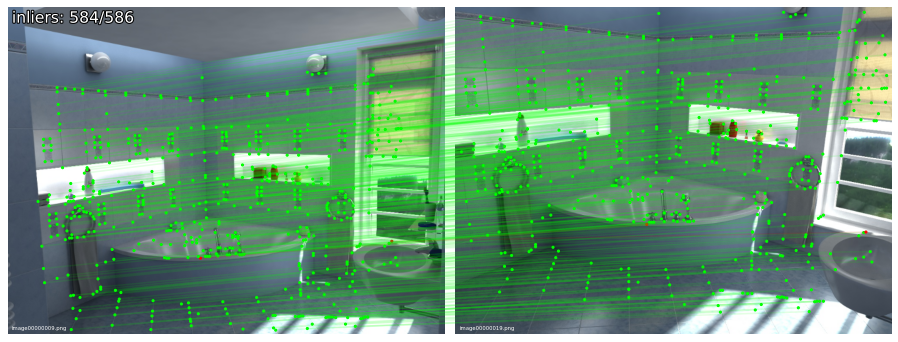

In [24]:
visualization.visualize_loc(
    results, images, reconstruction, n=1, top_k_db=1, seed=2
)